In [1]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import median_abs_deviation as mad
from scipy.stats import spearmanr, pearsonr
import numpy as np
import gseapy as gp
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

In [2]:
#tang_adata = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/tumor_adata_normalized_nescore.h5ad")
chan_adata = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/chan_adata_nescore.h5ad")

In [3]:
sclc_a_deg_file_path = "/hpc/users/divagt01/watanabe/Divagar/ChIP-seq-pipeline/tf_chip_rnaseq_integration/sclc_a_ccle_degs.txt"
sclc_n_deg_file_path = "/hpc/users/divagt01/watanabe/Divagar/ChIP-seq-pipeline/tf_chip_rnaseq_integration/sclc_n_ccle_degs.txt"
sclc_p_deg_file_path = "/hpc/users/divagt01/watanabe/Divagar/ChIP-seq-pipeline/tf_chip_rnaseq_integration/sclc_p_ccle_degs.txt"

In [4]:
sclc_a_degs = []
sclc_n_degs = []
sclc_p_degs = []


with open(sclc_a_deg_file_path, 'r') as f:
    for l in f:
        ll = l.split('\n')[0]
        sclc_a_degs.append(ll)

with open(sclc_n_deg_file_path, 'r') as f:
    for l in f:
        ll = l.split('\n')[0]
        sclc_n_degs.append(ll)

with open(sclc_p_deg_file_path, 'r') as f:
    for l in f:
        ll = l.split('\n')[0]
        sclc_p_degs.append(ll)

In [5]:
sclc_a_degs.sort()
sclc_n_degs.sort()
sclc_p_degs.sort()

In [6]:
sclc_subtype_gene_sets = {
    'A': sclc_a_degs,
    'N': sclc_n_degs,
    'P':sclc_p_degs
}

In [7]:
tang_expr_matrix_df = pd.DataFrame(tang_adata.X, index=tang_adata.obs_names, columns=tang_adata.var_names)

In [7]:
chan_expr_matrix_df = pd.DataFrame(chan_adata.X, index=chan_adata.obs_names, columns=chan_adata.var_names)

In [9]:
tang_gs_subtype_res = gp.ssgsea(
    data=tang_expr_matrix_df.T, # row = genes, col = cells
    gene_sets=sclc_subtype_gene_sets,
    min_size=5,
    sample_norm_method='rank', # Choose from {‘rank’, ‘log’, ‘log_rank’, None}
    correl_norm_type=None, # Choose from {‘rank’, ‘symrank’, ‘zscore’, None}
    threads=4,
)

In [10]:
tang_ssgsea_subtype_scores = tang_gs_subtype_res.results

In [12]:
sclca = []
sclcn = []
sclcp = []
cells1 = []

for cell_id, result in tang_ssgsea_subtype_scores.items():
    cells1.append(cell_id)
    sclca.append(result['A']['nes'])
    sclcn.append(result['N']['nes'])
    sclcp.append(result['P']['nes'])
    
sclc_subtype_df = pd.DataFrame({
    'A_ssgsea': sclca,
    'N_ssgsea': sclcn,
    'P_ssgsea': sclcp
}, index=cells1)

for i in range(len(cells1)):
    idx2 = tang_adata.obs_names.get_loc(cells1[i])
    tang_adata.obs.loc[cells1[i], 'A_ssgsea'] = sclca[i]
    tang_adata.obs.loc[cells1[i], 'N_ssgsea'] = sclcn[i]
    tang_adata.obs.loc[cells1[i], 'P_ssgsea'] = sclcp[i]

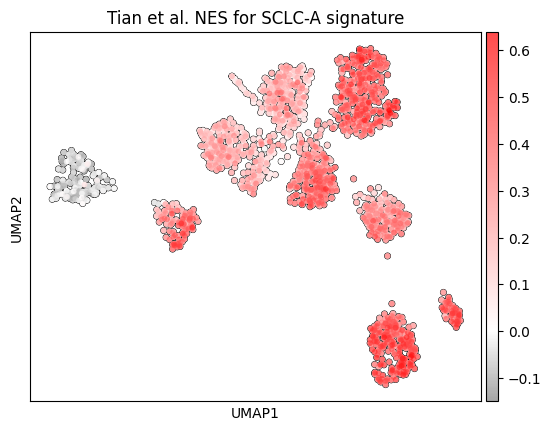

In [15]:
values = tang_adata.obs['A_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('grey_to_red', colors)

sc.pl.umap(tang_adata, color='A_ssgsea', cmap=cmap,title='Tian et al. NES for SCLC-A signature',show=False,add_outline=True,outline_width=(0.1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/tian_umap_a_score.png", dpi=600,bbox_inches='tight')

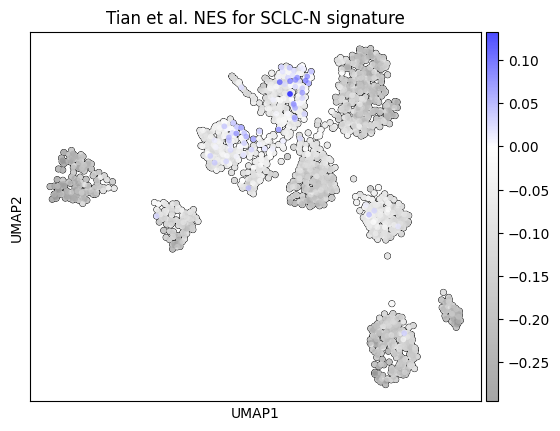

In [16]:
values = tang_adata.obs['N_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'blue')]
cmap = LinearSegmentedColormap.from_list('grey_to_blue', colors)

sc.pl.umap(tang_adata, color='N_ssgsea', cmap=cmap,title='Tian et al. NES for SCLC-N signature',show=False,add_outline=True,outline_width=(0.1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/tian_umap_n_score.png", dpi=600,bbox_inches='tight')

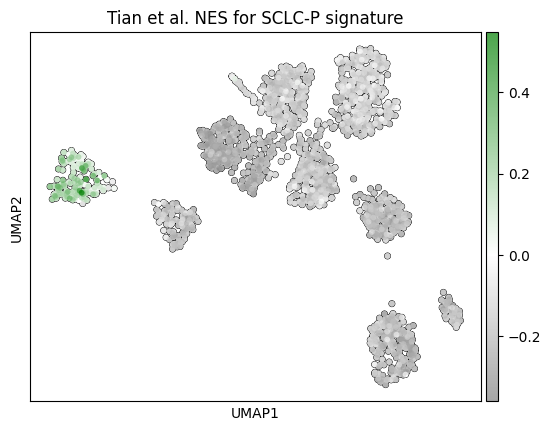

In [17]:
values = tang_adata.obs['P_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'green')]
cmap = LinearSegmentedColormap.from_list('grey_to_green', colors)

sc.pl.umap(tang_adata, color='P_ssgsea', cmap=cmap,title='Tian et al. NES for SCLC-P signature',show=False,add_outline=True,outline_width=(0.1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/tian_umap_p_score.png", dpi=600,bbox_inches='tight')

In [18]:
df = tang_adata.obs[['A_ssgsea', 'N_ssgsea', 'P_ssgsea']].copy()

# Function to assign subtype
def assign_subtype(row):
    max_score = row.max()
    if max_score <= 0:
        return 'TN'
    else:
        return {
            'A_ssgsea': 'SCLC-A',
            'N_ssgsea': 'SCLC-N',
            'P_ssgsea': 'SCLC-P'
        }[row.idxmax()]

# Apply function and save to new column
tang_adata.obs['SCLC_subtype'] = df.apply(assign_subtype, axis=1)

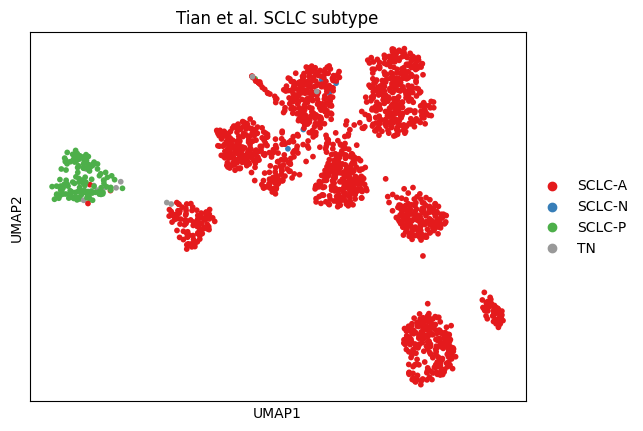

In [30]:
subtype_colors = ['#e41a1c',  # red for A
                  '#377eb8',  # blue for N
                  '#4daf4a',  # green for P
                  '#999999']  # grey for TN

# Plot
sc.pl.umap(
    tang_adata,
    color='SCLC_subtype',
    palette=subtype_colors,
    title='Tian et al. SCLC subtype',
    show=False
)
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/tian_umap_subtype.png", dpi=600,bbox_inches='tight')

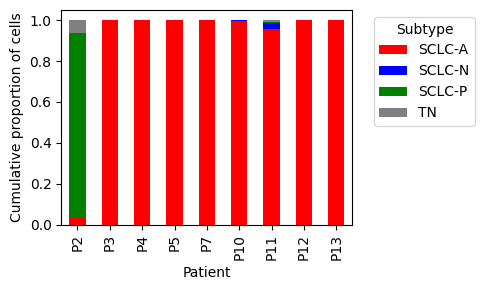

In [31]:
subtype_props = pd.crosstab(
    tang_adata.obs['patient'],
    tang_adata.obs['SCLC_subtype'],
    normalize='index'
)

# Optional: order the columns
subtype_order = ['SCLC-A', 'SCLC-N', 'SCLC-P', 'TN']
subtype_props = subtype_props.reindex(columns=subtype_order, fill_value=0)

# Plot
colors = {
    'SCLC-A': 'red',  # red
    'SCLC-N': 'blue',  # blue
    'SCLC-P': 'green',  # green
    'TN': 'grey'       # grey
}

ax = subtype_props.plot(kind='bar', stacked=True, figsize=(5, 3), color=[colors[col] for col in subtype_props.columns])

# Labels and title
ax.set_ylabel('Cumulative proportion of cells')
ax.set_xlabel('Patient')
ax.legend(title='Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/tian_bar_subtype.png", dpi=600,bbox_inches='tight')

In [32]:
tang_adata.write("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/tang_adata_normalized_nescore_subtyped.h5ad")

In [8]:
chan_gs_subtype_res = gp.ssgsea(
    data=chan_expr_matrix_df.T, # row = genes, col = cells
    gene_sets=sclc_subtype_gene_sets,
    min_size=5,
    sample_norm_method='rank', # Choose from {‘rank’, ‘log’, ‘log_rank’, None}
    correl_norm_type=None, # Choose from {‘rank’, ‘symrank’, ‘zscore’, None}
    threads=4,
)

In [9]:
chan_ssgsea_subtype_scores = chan_gs_subtype_res.results

In [10]:
sclca = []
sclcn = []
sclcp = []
cells1 = []

for cell_id, result in chan_ssgsea_subtype_scores.items():
    cells1.append(cell_id)
    sclca.append(result['A']['nes'])
    sclcn.append(result['N']['nes'])
    sclcp.append(result['P']['nes'])
    
sclc_subtype_df = pd.DataFrame({
    'A_ssgsea': sclca,
    'N_ssgsea': sclcn,
    'P_ssgsea': sclcp
}, index=cells1)

for i in range(len(cells1)):
    idx2 = chan_adata.obs_names.get_loc(cells1[i])
    chan_adata.obs.loc[cells1[i], 'A_ssgsea'] = sclca[i]
    chan_adata.obs.loc[cells1[i], 'N_ssgsea'] = sclcn[i]
    chan_adata.obs.loc[cells1[i], 'P_ssgsea'] = sclcp[i]

In [11]:
chan_adata.write("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/chan_adata_normalized_nescore_subtyped.h5ad")

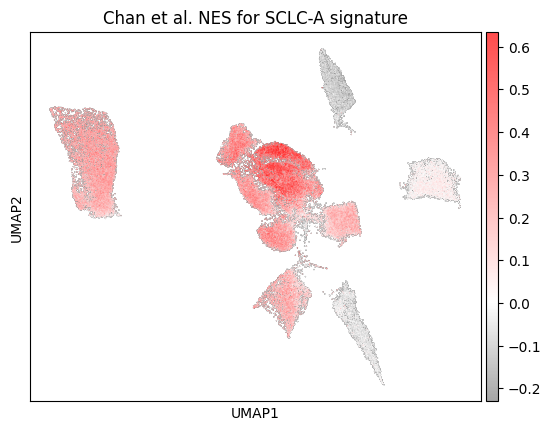

In [12]:
values = chan_adata.obs['A_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'red')]
cmap = LinearSegmentedColormap.from_list('grey_to_red', colors)

sc.pl.umap(chan_adata, color='A_ssgsea', cmap=cmap,title='Chan et al. NES for SCLC-A signature',show=False,add_outline=True,outline_width=(0.1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/chan_umap_a_score.png", dpi=600,bbox_inches='tight')

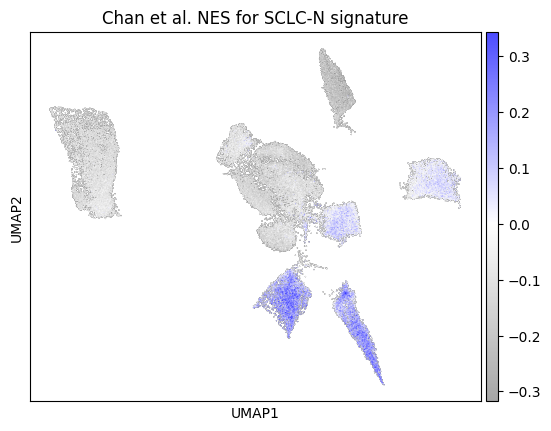

In [14]:
values = chan_adata.obs['N_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'blue')]
cmap = LinearSegmentedColormap.from_list('grey_to_blue', colors)

sc.pl.umap(chan_adata, color='N_ssgsea', cmap=cmap,title='Chan et al. NES for SCLC-N signature',show=False,add_outline=True,outline_width=(0.1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/chan_umap_n_score.png", dpi=600,bbox_inches='tight')

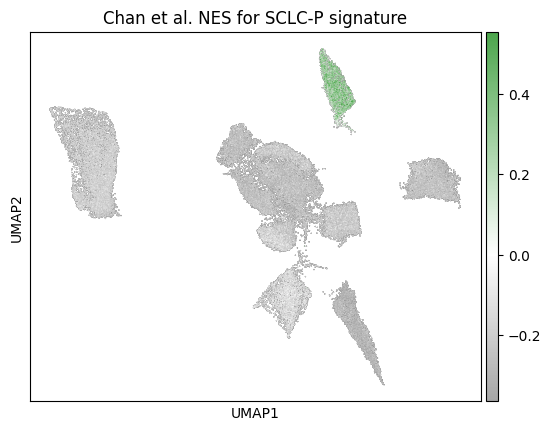

In [15]:
values = chan_adata.obs['P_ssgsea'].astype(float)
vmin = values.min()
vmax = values.max()
midpoint = 0

# Normalize the midpoint 
mid = (0 - vmin) / (vmax - vmin) 

colors = [(0, 'grey'), (mid, 'white'), (1, 'green')]
cmap = LinearSegmentedColormap.from_list('grey_to_green', colors)

sc.pl.umap(chan_adata, color='P_ssgsea', cmap=cmap,title='Chan et al. NES for SCLC-P signature',show=False,add_outline=True,outline_width=(0.1,0.001))
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/chan_umap_p_score.png", dpi=600,bbox_inches='tight')

In [2]:
tang_adata = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/tang_adata_normalized_nescore_subtyped.h5ad")
chan_adata = sc.read_h5ad("/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Chan/chan_adata_normalized_nescore_subtyped.h5ad")

In [216]:
def annotate_subtype(A, N, P):
    if A <= 0 and N <= 0 and P <= 0:
        return 'Triple Negative (TN)'
    if A > 0 and A > N and A > P and N <= 0 and P <= 0:
        return 'Purely SCLC-A'
    if N > 0 and N > A and N > P and A <= 0 and P <= 0:
        return 'Purely SCLC-N'
    if P > 0 and P > A and P > N and A <= 0 and N <= 0:
        return 'Purely SCLC-P'
    if A > 0 and N > 0 and P <= 0:
        return 'Mixed SCLC-A/N'
    return 'Others'

In [217]:
tang_adata.obs['SCLC Subtype'] = [
    annotate_subtype(A, N, P)
    for A, N, P in zip(tang_adata.obs['A_ssgsea'], tang_adata.obs['N_ssgsea'], tang_adata.obs['P_ssgsea'])
]


#chan_adata.obs['SCLC_subtype_ssgsea'] = df.apply(assign_subtype, axis=1)

In [218]:
chan_adata.obs['SCLC Subtype ssgsea'] = [
    annotate_subtype(A, N, P)
    for A, N, P in zip(chan_adata.obs['A_ssgsea'], chan_adata.obs['N_ssgsea'], chan_adata.obs['P_ssgsea'])
]

In [219]:
subtype_counts = chan_adata.obs['SCLC Subtype ssgsea'].value_counts()

# Calculate proportions
subtype_proportions = subtype_counts / chan_adata.n_obs

# Convert to DataFrame for nicer viewing (optional)
subtype_proportions_df = subtype_proportions.reset_index()
subtype_proportions_df.columns = ['SCLC Subtype ssgsea', 'Proportion']

print(subtype_proportions_df)

    SCLC Subtype ssgsea  Proportion
0         Purely SCLC-A    0.651364
1        Mixed SCLC-A/N    0.158700
2         Purely SCLC-N    0.089766
3         Purely SCLC-P    0.056939
4  Triple Negative (TN)    0.041501
5                Others    0.001731


In [220]:
subtype_counts = tang_adata.obs['SCLC Subtype'].value_counts()

# Calculate proportions
subtype_proportions = subtype_counts / tang_adata.n_obs

# Convert to DataFrame for nicer viewing (optional)
subtype_proportions_df = subtype_proportions.reset_index()
subtype_proportions_df.columns = ['SCLC Subtype', 'Proportion']

print(subtype_proportions_df)

           SCLC Subtype  Proportion
0         Purely SCLC-A    0.867957
1         Purely SCLC-P    0.071713
2        Mixed SCLC-A/N    0.044963
3                Others    0.007968
4  Triple Negative (TN)    0.006261
5         Purely SCLC-N    0.001138


In [221]:
chan_adata_filtered = chan_adata[~chan_adata.obs['SCLC Subtype ssgsea'].isin(['Triple Negative (TN)', 'Others'])].copy()


In [222]:
tang_adata_filtered = tang_adata[~tang_adata.obs['SCLC Subtype'].isin(['Triple Negative (TN)', 'Others'])].copy()


In [225]:
chan_adata_filtered.obs["SCLC Subtype ssgsea"].unique()

['Purely SCLC-N', 'Purely SCLC-A', 'Mixed SCLC-A/N', 'Purely SCLC-P']
Categories (4, object): ['Mixed SCLC-A/N', 'Purely SCLC-A', 'Purely SCLC-N', 'Purely SCLC-P']

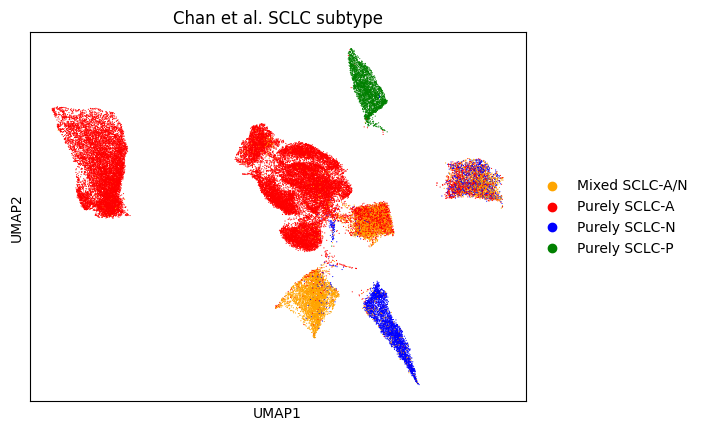

In [224]:
subtype_colors = {
    'Purely SCLC-A': 'red',
    'Purely SCLC-N': 'blue',
    'Purely SCLC-P': 'green',
    'Mixed SCLC-A/N': 'orange'
}

# Plot
sc.pl.umap(
    chan_adata_filtered,
    color='SCLC Subtype ssgsea',
    palette=subtype_colors,
    title='Chan et al. SCLC subtype',
    show=False
)
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/chan_umap_subtype.png", dpi=600,bbox_inches='tight')

KeyError: 'Purely SCLC-P'

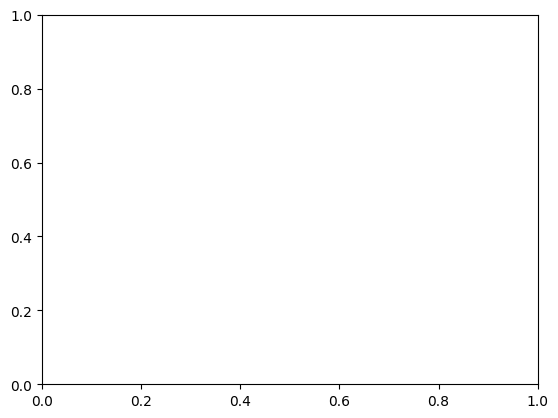

In [213]:
# Plot
sc.pl.umap(
    tang_adata_filtered,
    color='SCLC Subtype',
    palette=subtype_colors,
    title='Tian et al. SCLC subtype',
    show=False
)
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/tian_umap_subtype.png", dpi=600,bbox_inches='tight')

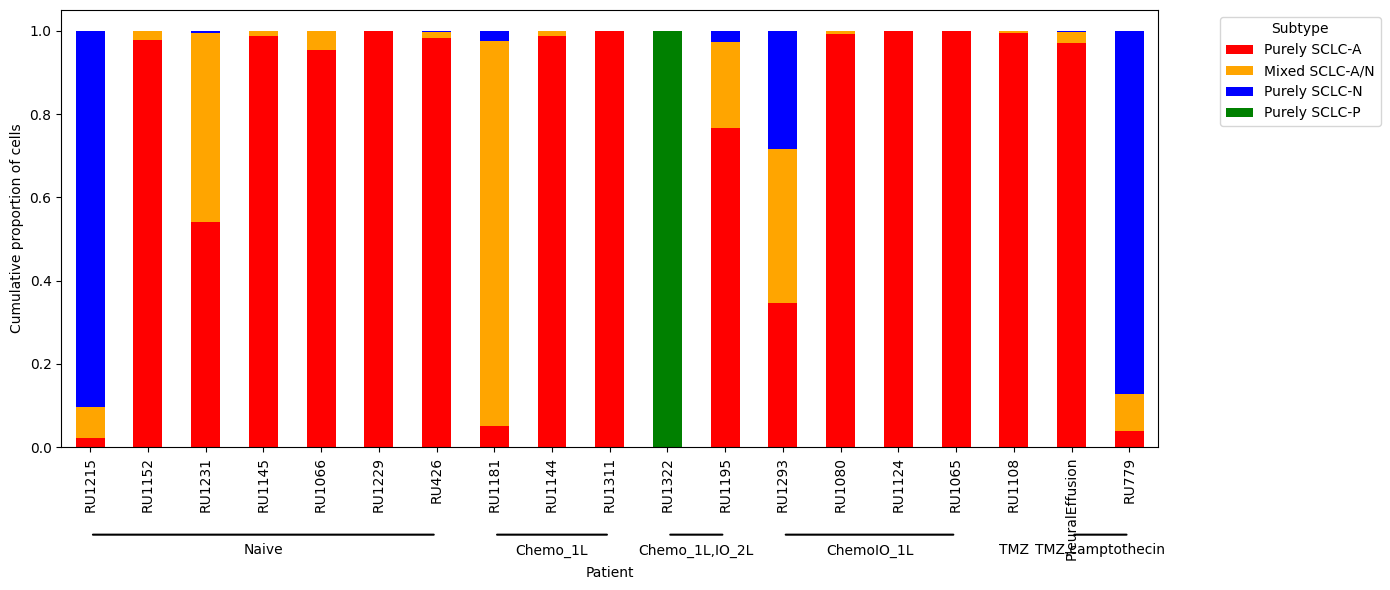

In [17]:
# Define patient groups
treatment_groups = {
    'Naive': ['RU1215', 'RU1152', 'RU1231', 'RU1145', 'RU1066', 'RU1229', 'RU426'],
    'Chemo_1L': ['RU1181', 'RU1144', 'RU1311'],
    'Chemo_1L,IO_2L': ['RU1322', 'RU1195'],
    'ChemoIO_1L': ['RU1293', 'RU1080', 'RU1124', 'RU1065'],
    'TMZ': ['RU1108'],
    'TMZ,camptothecin': ['PleuralEffusion', 'RU779']
}

# Flatten all patients in desired order
custom_patient_order = [p for group in treatment_groups.values() for p in group]

# Crosstab: subtype proportions
subtype_props = pd.crosstab(
    chan_adata_filtered.obs['patient'],
    chan_adata_filtered.obs['SCLC Subtype ssgsea'],
    normalize='index'
)
subtype_order = ['Purely SCLC-A', 'Mixed SCLC-A/N', 'Purely SCLC-N', 'Purely SCLC-P']
subtype_props = subtype_props.reindex(columns=subtype_order, fill_value=0)
subtype_props = subtype_props.reindex(custom_patient_order)

# Define colors
colors = {
    'Purely SCLC-A': 'red',
    'Mixed SCLC-A/N': 'orange',
    'Purely SCLC-N': 'blue',
    'Purely SCLC-P': 'green'
}

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
subtype_props.plot(
    kind='bar',
    stacked=True,
    color=[colors[c] for c in subtype_props.columns],
    ax=ax
)

# Labeling
ax.set_ylabel('Cumulative proportion of cells')
ax.set_xlabel('Patient')
ax.legend(title='Subtype', bbox_to_anchor=(1.05, 1), loc='upper left')

# Draw treatment group brackets under x-axis
xticks = ax.get_xticks()
for treatment, patients in treatment_groups.items():
    if not all(p in subtype_props.index for p in patients):
        continue
    start = custom_patient_order.index(patients[0])
    end = custom_patient_order.index(patients[-1])
    center = (start + end) / 2

    # Draw horizontal line
    ax.annotate(
        '', xy=(start, -0.2), xycoords=('data', 'axes fraction'),
        xytext=(end, -0.2), textcoords=('data', 'axes fraction'),
        arrowprops=dict(arrowstyle='-', lw=1.5)
    )
    # Add label
    ax.text(center, -0.22, treatment, ha='center', va='top', fontsize=10, transform=ax.get_xaxis_transform())

# Adjust plot
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/chan_bar_subtype.png", dpi=600,bbox_inches='tight')


In [21]:
chan_adata_filtered2 = chan_adata_filtered[chan_adata_filtered.obs['SCLC Subtype ssgsea'] != 'Purely SCLC-P'].copy()

In [24]:
sclc_a_mask = chan_adata_filtered2.obs['SCLC Subtype ssgsea'] == 'Purely SCLC-A'

# Get integer indices of those cells
sclc_a_indices = np.where(sclc_a_mask)[0]

# Pick a random integer index
root_cell_index = np.random.choice(sclc_a_indices)
chan_adata_filtered2.uns["iroot"] = root_cell_index

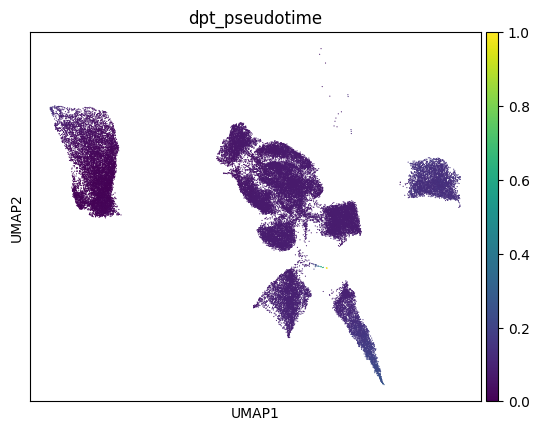

In [25]:
sc.tl.diffmap(chan_adata_filtered2)
sc.tl.dpt(chan_adata_filtered2)
sc.pl.umap(chan_adata_filtered2, color='dpt_pseudotime')

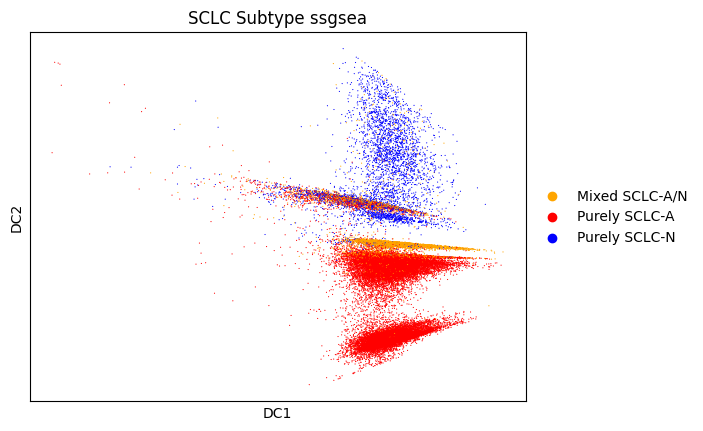

In [201]:
sc.pl.diffmap(chan_adata_filtered2, color='SCLC Subtype ssgsea')

In [203]:
chan_adata_filtered2

AnnData object with n_obs × n_vars = 44708 × 22216
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'mito_frac', 'RBP_frac', 'batch', 'patient', 'tissue', 'treatment', 'procedure', 'SCLC_subtype', 'SCLC_subtype_plus_TP53_RB1_wt', 'pval_SCLC-A', 'pval_SCLC-N', 'pval_SCLC-P', 'NEUROD genes', 'MHCI_PRESENTATION', 'MHCII_PRESENTATION', 'SCLC_major_subtype_of_sample', 'clusters', 'treatment_categorized', 'recurrent_cluster', 'histo', 'clusters_fine', 'n_genes', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'pearson_correlation_to_ne', 'pearson_correlation_to_nonne', 'NE_score', 'NE_status', 'A_ssgsea', 'N_ssgsea', 'P_ssgsea', 'SCLC Subtype ssgsea', 'dpt_pseudotime'
    var: 'knnDREMI|PLCG2', 'PLCG2_modules', 'AXONOGENESIS', 'NEURON_DIFFERENTIATION', 'NEUROPEPTIDE_RECEPTOR', 'EMT', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', '

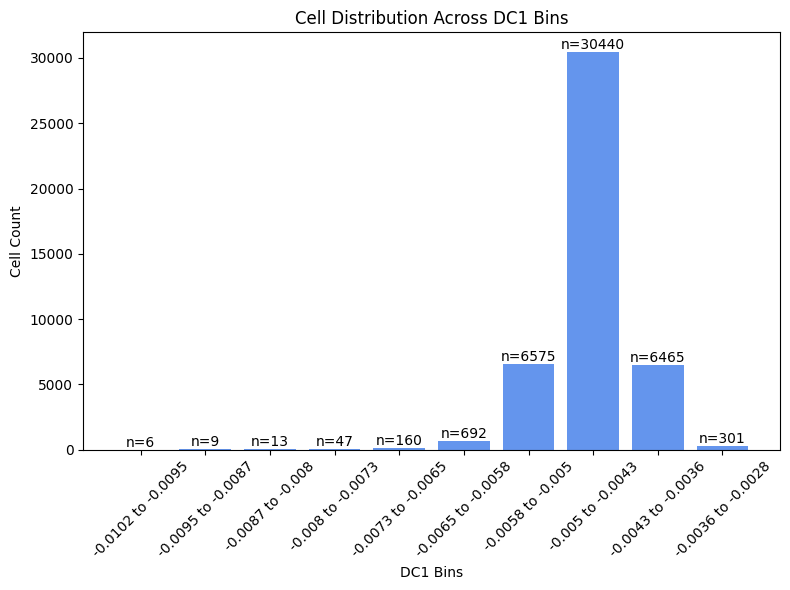

In [204]:
# Extract DC1 from the Diffusion Map components
DC1 = chan_adata_filtered2.obsm['X_diffmap'][:, 0]  # First diffusion component (DC1)

# Define the number of bins for DC1, e.g., 10 bins
num_bins = 10

# Create bin edges (using linspace to get evenly spaced bin edges)
bins = np.linspace(min(DC1), max(DC1), num_bins + 1)  # num_bins+1 because bin edges are one more than the number of bins

# Bin the DC1 values using digitize
binned_DC1 = np.digitize(DC1, bins)  # Get bin index for each DC1 value

# Ensure that bins are numbered from 1 to num_bins (clip the values)
binned_DC1 = np.clip(binned_DC1, 1, num_bins)  # Clip to prevent indexing out of bounds

# Count the number of cells in each bin
bin_counts = np.bincount(binned_DC1, minlength=num_bins + 1)[1:]  # Exclude the 0th bin (not needed)

# Create the bar plot for binned DC1 values
plt.figure(figsize=(8, 6))
bars = plt.bar(range(1, num_bins + 1), bin_counts, width=0.8, align='center', color='cornflowerblue')

# Set x-axis labels to show the bin ranges
bin_ranges = [f'{round(bins[i], 4)} to {round(bins[i + 1], 4)}' for i in range(num_bins)]
plt.xticks(range(1, num_bins + 1), bin_ranges, rotation=45)

# Label axes and title
plt.xlabel('DC1 Bins')
plt.ylabel('Cell Count')
plt.title('Cell Distribution Across DC1 Bins')

# Add 'n=' above each bin
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'n={int(bar.get_height())}', 
             ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

In [205]:
DC1 = chan_adata_filtered2.obsm['X_diffmap'][:, 0]  # First diffusion component (DC1)

# Define the threshold for DC1
threshold_dc1 = -0.0073

# Create a mask to filter cells where DC1 is above the threshold
mask = DC1 >= threshold_dc1

# Subset the AnnData object based on the mask
chan_adata_filtered4 = chan_adata_filtered2[mask]

In [206]:
chan_adata_filtered4

View of AnnData object with n_obs × n_vars = 44637 × 22216
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'mito_frac', 'RBP_frac', 'batch', 'patient', 'tissue', 'treatment', 'procedure', 'SCLC_subtype', 'SCLC_subtype_plus_TP53_RB1_wt', 'pval_SCLC-A', 'pval_SCLC-N', 'pval_SCLC-P', 'NEUROD genes', 'MHCI_PRESENTATION', 'MHCII_PRESENTATION', 'SCLC_major_subtype_of_sample', 'clusters', 'treatment_categorized', 'recurrent_cluster', 'histo', 'clusters_fine', 'n_genes', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'pearson_correlation_to_ne', 'pearson_correlation_to_nonne', 'NE_score', 'NE_status', 'A_ssgsea', 'N_ssgsea', 'P_ssgsea', 'SCLC Subtype ssgsea', 'dpt_pseudotime'
    var: 'knnDREMI|PLCG2', 'PLCG2_modules', 'AXONOGENESIS', 'NEURON_DIFFERENTIATION', 'NEUROPEPTIDE_RECEPTOR', 'EMT', 'n_cells', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_co

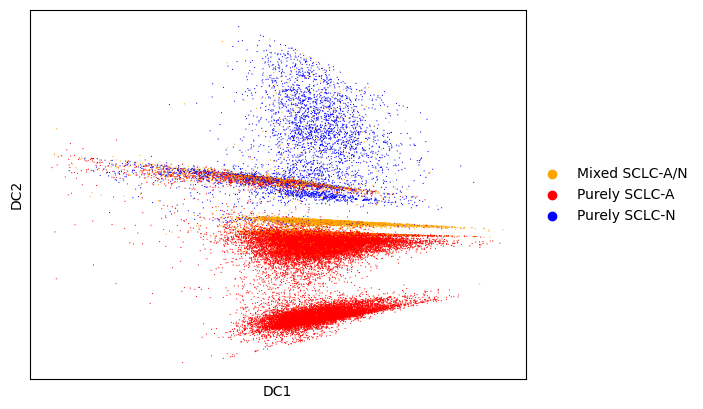

In [209]:
sc.pl.diffmap(chan_adata_filtered4, color='SCLC Subtype ssgsea', title='', show=False)
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/dc_filtered.png", dpi=600,bbox_inches='tight')

In [111]:
from tqdm import tqdm  # for progress bar


purely_a_cells = chan_adata_filtered4.obs[chan_adata_filtered4.obs['SCLC Subtype ssgsea'] == 'Purely SCLC-A']
purely_a_indices = np.where(chan_adata_filtered4.obs_names.isin(purely_a_cells.index))[0]

# Ensure diffusion map is computed only once for stability
sc.tl.diffmap(chan_adata_filtered4)

# Initialize matrix to collect 100 pseudotime runs
dpt_matrix = np.zeros((chan_adata_filtered4.n_obs, 1000))

# Run DPT 100 times with different random Purely SCLC-A roots
for i in tqdm(range(1000), desc="Running DPT 100x"):
    # Pick a random Purely SCLC-A cell
    random_cell_idx = np.random.choice(purely_a_indices)

    # Set root and run DPT
    chan_adata_filtered4.uns["iroot"] = random_cell_idx
    sc.tl.dpt(chan_adata_filtered4)

    # Store the pseudotime
    dpt_matrix[:, i] = chan_adata_filtered4.obs['dpt_pseudotime'].values

# Average across runs and assign to obs
chan_adata_filtered4.obs['dpt_pseudotime'] = dpt_matrix.mean(axis=1)

# Plot UMAP with averaged pseudotime
sc.pl.umap(chan_adata_filtered4, color='dpt_pseudotime')

AttributeError: 'PathCollection' object has no attribute 'tl'

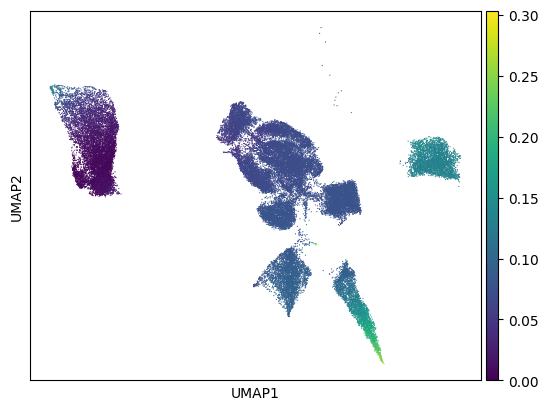

In [212]:
sc.pl.umap(chan_adata_filtered4, color='dpt_pseudotime',title='', show=False)
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/dpt_umap.png", dpi=600,bbox_inches='tight')

In [72]:
finite_mask = np.isfinite(chan_adata_filtered4.obs['dpt_pseudotime'])

# Subset the AnnData object
chan_adata_filtered4 = chan_adata_filtered4[finite_mask].copy()


In [74]:
df = chan_adata_filtered4.obs[['dpt_pseudotime', 'SCLC Subtype ssgsea']].copy()
df = df.sort_values(by='dpt_pseudotime').reset_index(drop=True)

# Map subtypes to colors
subtype_colors = {
    'Purely SCLC-A': 'red',
    'Purely SCLC-N': 'blue',
    'Mixed SCLC-A/N': 'orange',
}

# Convert subtypes to color list
colors = df['SCLC Subtype ssgsea'].map(subtype_colors).values

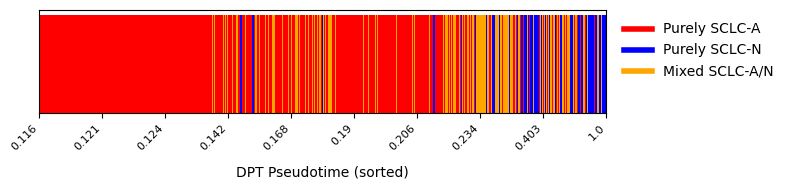

In [78]:
# Set up the plot
fig, ax = plt.subplots(figsize=(8, 2))  # Increased height for visibility

# Draw one bar per cell
ax.bar(range(len(df)), [1]*len(df), color=colors, width=2.0)

# Configure x-axis with DPT labels
num_ticks = 10
tick_positions = np.linspace(0, len(df) - 1, num=num_ticks, dtype=int)
tick_labels = df.loc[tick_positions, 'dpt_pseudotime'].round(3).values

ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=8)
ax.set_yticks([])
ax.set_xlim(0, len(df))

ax.set_xlabel('DPT Pseudotime (sorted)', labelpad=10)

# Legend
handles = [plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in subtype_colors.items()]
ax.legend(handles=handles, bbox_to_anchor=(1.01, 1), loc='upper left', frameon=False)

plt.tight_layout()
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/chan_bar_dpt.png", dpi=600,bbox_inches='tight')

In [134]:
# Initialize results list
results = []

# Access pseudotime
dpt = chan_adata_filtered4.obs['dpt_pseudotime'].values
genes = chan_adata_filtered4.var_names

# Initialize the progress bar with tqdm
for gene in tqdm(genes, desc="Processing genes", unit="gene"):
    # Get gene expression
    expr = chan_adata_filtered4[:, gene].X

    # Convert sparse to dense if needed
    if hasattr(expr, "toarray"):
        expr = expr.toarray()
    expr = expr.flatten()

    # Filter out zero expression
    mask = expr > 0
    if np.sum(mask) < 50:
        continue  # skip genes with too few data points

    dpt_filtered = dpt[mask]
    expr_filtered = expr[mask]

    # Handle warnings for constant inputs (no variance)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            r, p = pearsonr(dpt_filtered, expr_filtered)
            results.append({'gene': gene, 'r': r, 'pval': p})
        except Exception:
            continue

# Convert to DataFrame
df = pd.DataFrame(results)

# Apply FDR correction
df['pval_adj'] = multipletests(df['pval'], method='fdr_bh')[1]

# Sort by adjusted p-value or correlation
df = df.sort_values('pval_adj')

# View top results
df.head()

Processing genes: 100%|██████████| 22216/22216 [08:51<00:00, 41.81gene/s]


,gene,r,pval,pval_adj
2394,CAMK1D,-0.292778,0.0,0.0
6059,FTH1,-0.305630,0.0,0.0
14883,RRP1B,0.338963,0.0,0.0
4550,DLK2,0.581403,0.0,0.0
4524,DKC1,0.279001,0.0,0.0


In [153]:
upregulated_genes = df[(df['r'] > 0.5) & (df['pval_adj'] < 0.05)]['gene'].tolist()

In [154]:
len(upregulated_genes)

53

In [155]:
with open('upregulated_genes.txt', 'w') as f:
    for gene in upregulated_genes:
        f.write(f"{gene}\n")

In [159]:
downregulated_genes = df[(df['r'] < -0.4) & (df['pval_adj'] < 0.05)]['gene'].tolist()

In [160]:
len(downregulated_genes)

49

In [161]:
with open('downregulated_genes.txt', 'w') as f:
    for gene in downregulated_genes:
        f.write(f"{gene}\n")

In [192]:
myc_genes = [
    "ABCE1","ACP1","AIMP2","AP3S1","APEX1","BUB3","C1QBP","CAD","CANX","CBX3","CCNA2","CCT2","CCT3","CCT4","CCT5","CCT7",
    "CDC20","CDC45","CDK2","CDK4","CLNS1A","CNBP","COPS5","COX5A","CSTF2","CTPS1","CUL1","CYC1","DDX18","DDX21","DEK","DHX15",
    "DUT","EEF1B2","EIF1AX","EIF2S1","EIF2S2","EIF3B","EIF3D","EIF3J","EIF4A1","EIF4E","EIF4G2","EIF4H","EPRS1","ERH","ETF1","EXOSC7",
    "FAM120A","FBL","G3BP1","GLO1","GNL3","GOT2","GSPT1","H2AZ1","HDAC2","HDDC2","HDGF","HNRNPA1","HNRNPA2B1","HNRNPA3","HNRNPC",
    "HNRNPD","HNRNPR","HNRNPU","HPRT1","HSP90AB1","HSPD1","HSPE1","IARS1","IFRD1","ILF2","IMPDH2","KARS1","KPNA2","KPNB1","LDHA",
    "LSM2","LSM7","MAD2L1","MCM2","MCM4","MCM5","MCM6","MCM7","MRPL23","MRPL9","MRPS18B","MYC","NAP1L1","NCBP1","NCBP2","NDUFAB1",
    "NHP2","NME1","NOLC1","NOP16","NOP56","NPM1","ODC1","ORC2","PA2G4","PABPC1","PABPC4","PCBP1","PCNA","PGK1","PHB1","PHB2",
    "POLD2","POLE3","PPIA","PPM1G","PRDX3","PRDX4","PRPF31","PRPS2","PSMA1","PSMA2","PSMA4","PSMA6","PSMA7","PSMB2","PSMB3",
    "PSMC4","PSMC6","PSMD1","PSMD14","PSMD3","PSMD7","PSMD8","PTGES3","PWP1","RACK1","RAD23B","RAN","RANBP1","RFC4","RNPS1","RPL14",
    "RPL18","RPL22","RPL34","RPL6","RPLP0","RPS10","RPS2","RPS3","RPS5","RPS6","RRM1","RRP9","RSL1D1","RUVBL2","SERBP1","SET",
    "SF3A1","SF3B3","SLC25A3","SMARCC1","SNRPA","SNRPA1","SNRPB2","SNRPD1","SNRPD2","SNRPD3","SNRPG","SRM","SRPK1","SRSF1","SRSF2",
    "SRSF3","SRSF7","SSB","SSBP1","STARD7","SYNCRIP","TARDBP","TCP1","TFDP1","TOMM70","TRA2B","TRIM28","TUFM","TXNL4A","TYMS",
    "U2AF1","UBA2","UBE2E1","UBE2L3","USP1","VBP1","VDAC1","VDAC3","XPO1","XPOT","XRCC6","YWHAE","YWHAQ"
]

notch_genes = [
    "APH1A","ARRB1","CCND1","CUL1","DLL1","DTX1","DTX2","DTX4","FBXW11","FZD1","FZD5","FZD7","HES1","HEYL","JAG1","KAT2A","LFNG",
    "MAML2","NOTCH1","NOTCH2","NOTCH3","PPARD","PRKCA","PSEN2","PSENEN","RBX1","SAP30","SKP1","ST3GAL6","TCF7L2","WNT2","WNT5A"
]


In [193]:
def compute_score(adata, gene_list, score_name):
    genes_in_data = [g for g in gene_list if g in adata.var_names]
    sc.tl.score_genes(adata, gene_list=genes_in_data, score_name=score_name)
    df = adata.obs[['dpt_pseudotime', score_name]].copy()
    df_sorted = df.sort_values(by='dpt_pseudotime')
    df_sorted[f'{score_name}_smooth'] = df_sorted[score_name].rolling(window=50, center=True, min_periods=1).mean()
    return df_sorted

df_myc = compute_score(chan_adata_filtered4, myc_genes, 'myc_score')
df_notch = compute_score(chan_adata_filtered4, notch_genes, 'notch_score')


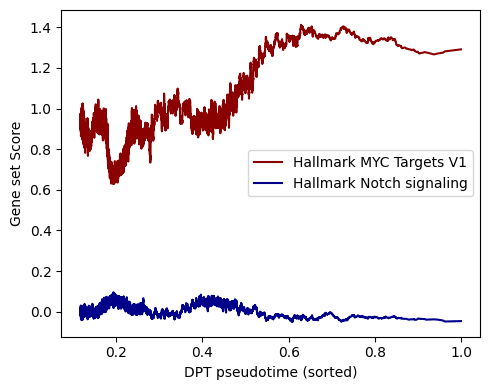

In [210]:
plt.figure(figsize=(5, 4))
plt.plot(df_myc['dpt_pseudotime'], df_myc['myc_score_smooth'], label='Hallmark MYC Targets V1', color='darkred')
plt.plot(df_notch['dpt_pseudotime'], df_notch['notch_score_smooth'], label='Hallmark Notch signaling', color='darkblue')
plt.xlabel('DPT pseudotime (sorted)')
plt.ylabel('Gene set Score')
plt.legend()
plt.tight_layout()
plt.savefig("/hpc/users/divagt01/watanabe/Divagar/scRNAseq_pipeline/figures/geneset_dpt.png", dpi=600,bbox_inches='tight')